In [1]:
from tensorflow import keras
from keras.applications import VGG16
from keras.layers import Dense,Activation,Input,Dropout,Flatten
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from scipy.io import loadmat
import glob
import numpy as np
import cv2

Using TensorFlow backend.


In [2]:
# box_coord = (starting y, ending y, starting x, ending x)
# bounding box and label for faces
faces = []
for p in glob.glob(r".\annotations\Faces_2" + r'\*.mat'):
    (y_start,y_end,x_start,x_end) = loadmat(p)["box_coord"][0]
    faces.append([x_start,y_start,x_end,y_end])

In [3]:
from imutils import paths 
imagePaths = list(paths.list_images(r'.\dataset\Faces'))
f = open(r".\annotation_csv\face.csv","w")
n = len(imagePaths)
f.write("Filename,x_start,y_start,x_end,y_end,label\n")
for i in range(n):
    row = faces[i]
    f.write("{},{},{},{},{},face\n".format(imagePaths[i][-14:],row[0],row[1],row[2],row[3]))
f.close()

In [4]:
# Bounding Box and label for Airplanes
airplane = []
for p in glob.glob(r".\annotations\Airplanes_Side_2" + r'\*.mat'):
    (y_start,y_end,x_start,x_end) = loadmat(p)["box_coord"][0]
    airplane.append([x_start,y_start,x_end,y_end])
imagePaths = list(paths.list_images(r'.\dataset\airplanes'))
f = open(r".\annotation_csv\airplane.csv","w")
n = len(imagePaths)
f.write("Filename,x_start,y_start,x_end,y_end,label\n")
for i in range(n):
    row = airplane[i]
    f.write("{},{},{},{},{},airplane\n".format(imagePaths[i][-14:],row[0],row[1],row[2],row[3]))
f.close()

In [5]:
# Bounding Box and label for Motorbikes
motorbikes = []
for p in glob.glob(r".\annotations\Motorbikes_16" + r'\*.mat'):
    (y_start,y_end,x_start,x_end) = loadmat(p)["box_coord"][0]
    motorbikes.append([x_start,y_start,x_end,y_end])
imagePaths = list(paths.list_images(r'.\dataset\Motorbikes'))
f = open(r".\annotation_csv\motorbike.csv","w")
n = len(imagePaths)
f.write("Filename,x_start,y_start,x_end,y_end,label\n")
for i in range(n):
    row = motorbikes[i]
    f.write("{},{},{},{},{},motorbike\n".format(imagePaths[i][-14:],row[0],row[1],row[2],row[3]))
f.close()

In [6]:
data_faces = pd.read_csv(r".\annotation_csv\face.csv")
data_airplanes = pd.read_csv(r".\annotation_csv\airplane.csv")
data_motorcycle = pd.read_csv(r".\annotation_csv\motorbike.csv")


In [7]:
# Getting all the labels in one dataframe
df = pd.concat([data_airplanes,data_faces,data_motorcycle],axis=0)

In [21]:
from imutils import paths
from keras.preprocessing.image import load_img,img_to_array

In [28]:
images = []
bbox = []
labels = []

for index,row in df.iterrows():
    im = cv2.imread(r".\dataset\{}\{}".format(row['label'],row['Filename']))
    (h,w) = im.shape[:2]
    im = load_img(r".\dataset\{}\{}".format(row['label'],row['Filename']),target_size=(224,224))
    im = img_to_array(im)

    images.append(im)

    [x_start,y_start,x_end,y_end] = [row['x_start'],row['y_start'],row['x_end'],row['y_end']]
    x_start = float(x_start) / w
    x_end = float(x_end) / w
    y_start = float(y_start) / h 
    y_end = float(y_end) / h 

    bbox.append([x_start,y_start,x_end,y_end])

    labels.append(row['label'])  

In [29]:
images = np.array(images) / 255.0
labels = np.array(labels)
bbox = np.array(bbox)

In [30]:
# converting labels to keras accepted form
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [31]:
# Train Test split
from sklearn.model_selection import train_test_split

split = train_test_split(images, labels, bbox, test_size=0.20, random_state=42)

(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
#(trainPaths, testPaths) = split[6:]


In [32]:
# Now,comes the model

vgg = VGG16(weights="imagenet", include_top= False,input_tensor=Input(shape=(224, 224, 3)))

for layer in vgg.layers:
    layer.trainable = False

In [33]:
flatten = vgg.output
flatten = Flatten()(flatten)

# bbox
regressionHead = Dense(128, activation='relu')(flatten)
regressionHead = Dense(64, activation="relu")(regressionHead)
regressionHead = Dense(32, activation='relu')(regressionHead)
regressionHead = Dense(4, activation='sigmoid',name = "bounding_box")(regressionHead)

# Classification
softmaxHead = Dense(512,activation='relu')(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation='relu')(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(3, activation='softmax',name = "class_label")(softmaxHead)

model = Model(inputs = vgg.input, outputs = (regressionHead,softmaxHead))


In [34]:
# Training the model
#INIT_LR = 1e-4
#NUM_EPOCHS = 20
#BATCH_SIZE = 32
from keras.optimizers import Adam
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}

lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}

opt = Adam(lr = 1e-4)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [35]:
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [36]:
H = model.fit(
	trainImages, trainTargets,
	validation_data = (testImages, testTargets),
	batch_size = 32,
	epochs = 20,
	verbose = 1)

Train on 1626 samples, validate on 407 samples
Epoch 1/20
1626/1626 [==============================] - 57s 35ms/step - loss: 0.1983 - bounding_box_loss: 0.0068 - class_label_loss: 0.1908 - bounding_box_accuracy: 0.7927 - class_label_accuracy: 0.9256 - val_loss: 0.0049 - val_bounding_box_loss: 0.0012 - val_class_label_loss: 0.0037 - val_bounding_box_accuracy: 0.8108 - val_class_label_accuracy: 0.9975
Epoch 2/20
1626/1626 [==============================] - 29s 18ms/step - loss: 0.0099 - bounding_box_loss: 0.0011 - class_label_loss: 0.0087 - bounding_box_accuracy: 0.8549 - class_label_accuracy: 0.9994 - val_loss: 0.0024 - val_bounding_box_loss: 9.3146e-04 - val_class_label_loss: 0.0015 - val_bounding_box_accuracy: 0.8256 - val_class_label_accuracy: 1.0000
Epoch 3/20
1626/1626 [==============================] - 30s 18ms/step - loss: 0.0058 - bounding_box_loss: 7.8909e-04 - class_label_loss: 0.0050 - bounding_box_accuracy: 0.8629 - class_label_accuracy: 0.9994 - val_loss: 0.0018 - val_bound

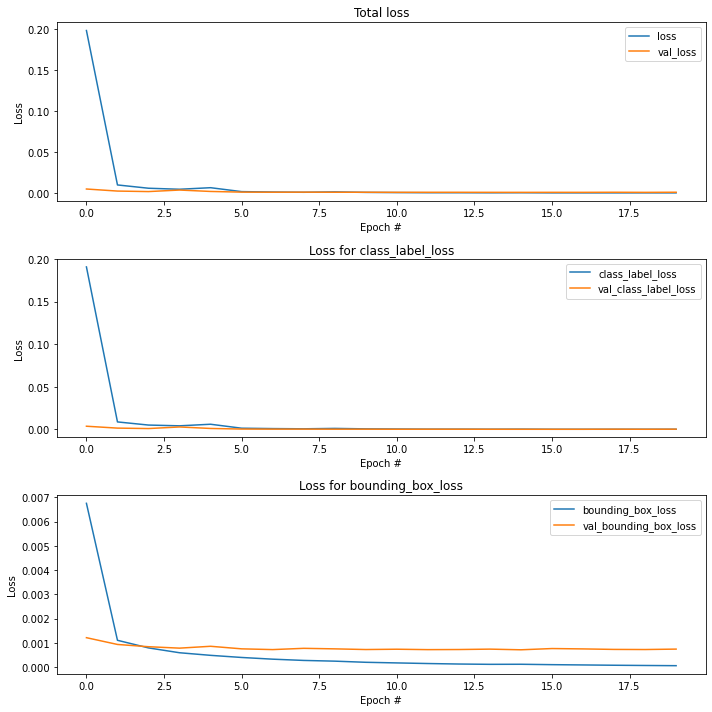

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, 20)

(fig, ax) = plt.subplots(3, 1, figsize=(10,10))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()

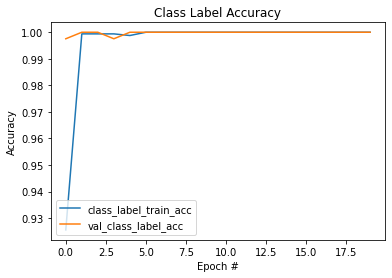

In [38]:
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")


In [39]:
# save the model
import pickle
model.save(r".\model\detector.h5")
# serialize the label binarizer to disk
f = open(r".\model\label_binarizer.h5", "wb")
f.write(pickle.dumps(lb))
f.close()